<a href="https://colab.research.google.com/github/pranavkantgaur/Coursera_DL_specialization_from_scratch/blob/master/course1/week4/build_nn_step_by_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objectives
To be able to build and train NNs for various depth and width. This assignment is not tied to any application, therefore it will be evaluated using test cases. The functions developed in this notebook will be used in the next assignment. Target is to build:


*   A 2-layer NN
*   A L-layer NN

Effectively, I will be able to build and train a L-layer fully connected NN, entirely using Numpy.


## Load dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plotting
import h5py # data loading for hdf5 dataset
from PIL import Image # for loading your images for processing
from scipy import ndimage 
import os


In [0]:
# implementing utility function for loading cat vs non-cat datasets
def load_dataset():
  train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
  test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
  train_set_x = np.array(train_dataset["train_set_x"][:])
  train_set_y = np.array(train_dataset["train_set_y"][:])
  test_set_x  = np.array(test_dataset["test_set_x"][:])
  test_set_y = np.array(test_dataset["test_set_y"][:])
  classes = np.array(train_dataset["list_classes"][:])

  # lets reshape the arrays
  train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
  test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

  return train_set_x, train_set_y, test_set_x, test_set_y, classes

In [0]:
# load training dataset
x_train_images, y_train_images, x_test_images, y_test_images, classes = load_dataset()
# x_train_images: (m, nx, ny, nc)
# y_train_images: (1, m)

y =  1 Its a cat picture!!


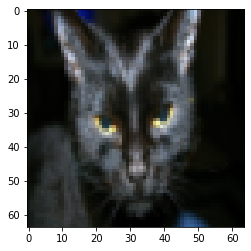

In [0]:
# lets inspect the dataset
image_id = 25
plt.imshow(x_train_images[image_id])
print("y = ", y_train_images[0][image_id], "Its a " + classes[y_train_images[0][image_id]].decode("utf-8") + " picture!!")

In [0]:
# lets inspect the shapes of the dataset arrays
print("Training set shape: ", x_train_images.shape) #  m, nx, ny, nc
print("Training set labels shape: ", y_train_images.shape) # 1, m
print("Test set shape: ", x_test_images.shape)
print("Test set labels shape: ", y_test_images.shape)
print("Each image is of shape: ", x_train_images[0].shape)

Training set shape:  (209, 64, 64, 3)
Training set labels shape:  (1, 209)
Test set shape:  (50, 64, 64, 3)
Test set labels shape:  (1, 50)
Each image is of shape:  (64, 64, 3)


In [0]:
# Lets flatten the train and test image dataset for training
x_train_images_flattened = x_train_images.reshape((x_train_images.shape[0], x_train_images.shape[1] * 
                                                   x_train_images.shape[2] * 
                                                   x_train_images.shape[3], 1)) 
x_train_images_flattened = np.squeeze(x_train_images_flattened)
x_train_images_flattened = x_train_images_flattened.T
x_test_images_flattened = x_test_images.reshape((x_test_images.shape[0], x_train_images.shape[1] * 
                                                 x_test_images.shape[2] * 
                                                 x_test_images.shape[3], 1))

x_test_images_flattened = np.squeeze(x_test_images_flattened)
x_test_images_flattened = x_test_images_flattened.T

# lets print
print("Flattened version of train images: ", x_train_images_flattened.shape)
print("Label set for training dataset: ", y_train_images.shape)
print("Flattened version of test images: ", x_test_images_flattened.shape)
print("Label set for test dataset: ", y_test_images.shape)


print("Sanity check after reshaping: ", x_train_images_flattened[0:5, 0])

Flattened version of train images:  (12288, 209)
Label set for training dataset:  (1, 209)
Flattened version of test images:  (12288, 50)
Label set for test dataset:  (1, 50)
Sanity check after reshaping:  [17 31 56 22 33]


In [0]:
# normalization
x_train_images = x_train_images_flattened / 255.0
x_test_images = x_test_images_flattened / 255.0

In [0]:
def sigmoid(z):
  sig = 1 / (1 + np.exp(-z))
  return sig

In [0]:
class TwoLayerNN(object):
  def __init__(self, n_hidden_units):
    # hyperparameters
    self.n_hidden_units = n_hidden_units # len(self.n_hidden_units = number of layers)
    self.n_epochs = 0
    self.lr = 0
    # parameters
    self.w1 = 0
    self.b1 = 0
    self.w2 = 0
    self.b2 = 0


  def forward(self, X):
    # layer 1
    z1 = np.dot(self.w1, X) + self.b1
    a1 = np.tanh(z1)
    
    # layer 2
    z2 = np.dot(self.w2, a1) + self.b2
    a2 = sigmoid(z2)

    return a1, a2

  def initialize_parameters(self, input_size):
    self.w1 = np.random.randn(self.n_hidden_units[0], input_size) * 0.01
    self.b1 = np.zeros((self.n_hidden_units[0], 1))
    self.w2 = np.random.randn(self.n_hidden_units[1], self.n_hidden_units[0]) * 0.01
    self.b2 = np.zeros((self.n_hidden_units[1], 1))
    


  def backward(self, A1, A2, X, Y):
    '''
    Notice that the only difference across layers lies in computation of dZ, 
    rest all can be parameterized on layer ID.
    '''
    m = X.shape[1]

    dZ2 = A2 - Y # output layer
    dw2 = np.dot(dZ2, A1.T) / m
    db2 = np.mean(dZ2)
    
    dZ1 = np.dot(self.w2.T, dZ2) * (1 - np.power(A1, 2))
    dw1 = np.dot(dZ1, X.T) / m
    db1 = np.mean(dZ1)

    return dw1, db1, dw2, db2

  def update_parameters(self, dw1, db1, dw2, db2):
    self.w1 = self.w1 - self.lr * dw1
    self.b1 = self.b1 - self.lr * db1
    self.w2 = self.w2 - self.lr * dw2
    self.b2 = self.b2 - self.lr * db2


  def compute_cost(self, A, Y):
    cost = -float((np.dot(Y, np.log(A).T) + np.dot(1-Y, np.log(1-A).T))) / Y.shape[1]  
    return cost
  
  def train(self, X, Y, lr = 0.001, n_epochs = 1000):
    self.initialize_parameters(X.shape[0]) 
    self.lr = lr
    self.n_epochs = n_epochs

    for i in range(n_epochs):
      A1, A2  = self.forward(X)
      dw1, db1, dw2, db2 = self.backward(A1, A2, X, Y)     
      self.update_parameters(dw1, db1, dw2, db2)
      cost = self.compute_cost(A2, Y)
      if (i % 100 == 0):
        print("Cost at epoch: ", i, "is: ", cost)
    # save final parameters
    try:  
      os.mkdir("params")  
    except OSError as error:  
      print(error)   
    np.save("params/w1.npy", self.w1)    
    np.save("params/b1.npy", self.b1)
    np.save("params/w2.npy", self.w2)
    np.save("params/b2.npy", self.b2)

  def evaluate(self, X_test, Y_test):
    self.w1 = np.load("params/w1.npy")         
    self.b1 = np.load("params/b1.npy")
    self.w2 = np.load("params/w2.npy")
    self.b2 = np.load("params/b2.npy")

    _, A_predict = self.forward(X_test)

    Y_predict = (A_predict > 0.5)
    accuracy = 100 * float(np.dot(Y_test, Y_predict.T) + 
                           np.dot(1-Y_test, (1-Y_predict).T)) / Y_test.shape[1]
    print("Accuracy of trained model: ", accuracy)              
   

In [0]:
twoNN = TwoLayerNN(n_hidden_units = [7, 1])

In [0]:
twoNN.train(x_train_images, y_train_images, lr = 0.0075, n_epochs = 2500)

Cost at epoch:  0 is:  0.6925732572537425
Cost at epoch:  100 is:  0.6496883030701376
Cost at epoch:  200 is:  0.6412165650881596
Cost at epoch:  300 is:  0.6278579495819233
Cost at epoch:  400 is:  0.6015550519072044
Cost at epoch:  500 is:  0.5621130154731159
Cost at epoch:  600 is:  0.5134103983299865
Cost at epoch:  700 is:  0.45991319207777753
Cost at epoch:  800 is:  0.4042203172119329
Cost at epoch:  900 is:  0.3511061137237675
Cost at epoch:  1000 is:  0.3623072589718516
Cost at epoch:  1100 is:  0.31654212145440463
Cost at epoch:  1200 is:  0.27903809146365904
Cost at epoch:  1300 is:  0.2443853473870132
Cost at epoch:  1400 is:  0.21082335948320144
Cost at epoch:  1500 is:  0.17870469456304985
Cost at epoch:  1600 is:  0.14233455415208388
Cost at epoch:  1700 is:  0.12362876465814868
Cost at epoch:  1800 is:  0.10985738636964573
Cost at epoch:  1900 is:  0.09829515114787374
Cost at epoch:  2000 is:  0.08825006109665892
Cost at epoch:  2100 is:  0.0794286273937023
Cost at epoc

In [0]:
# train accuracy
twoNN.evaluate(x_train_images, y_train_images)

Accuracy of trained model:  100.0


In [0]:
# test accuracy
twoNN.evaluate(x_test_images, y_test_images)

Accuracy of trained model:  72.0


## Generalizing to L-layer NN
Now we want to generalize the above 2-layer NN to a L-layer NN, the interface should be such that:

* For L=2 and keeping other hyper-parameters same, we should be able to reproduce  the results obtained above. In other words, training a `LLayerNN(n_hidden_units = [7, 1])` network as `lllayerNN.train(x_train_images, y_train_images, lr = 0.0075, n_epochs = 2500)` should result in $72\%$ test and $100\%$ train accuracy.
*   NN should be implemented by stacking layer along both forward and backward directions:
  * forward:  
      * Layers:
        * hidden layers with tanh/relu activation
        * output layer with sigmoid activation
      * Input:
        * activation from last layer
        * weight(and bias) matrix for current layer
      * Output:
        * activation from current layer        
  * backward:
      * Layers:
        * hidden backward propogation layer
        * output bacwkard propogation layer
      * Input:
        * activation from successive layer
        * weight metrix from successive layer
        * gradients from successive layer
      * Output:
        * gradients for current layer, $dw$, $db$ and $dz$.        

In [0]:
# Assumes a binary problem.
class LLayerNN(object):
  def __init__(self, n_hidden_units):
    self.w = [] # (n_hidden_layers + 1)
    self.b = [] 
    self.dw = [] # same as w
    self.db = []
    self.dz = []
    self.a = [] # (n_hidden_layers + 1)
    self.lr = 0
    self.n_hidden_units = n_hidden_units #total number of layers, n_hidden_units + 1
    
  def initialize_parameters(self, input_size):
    # w[0], b[0]
    self.w.append(np.random.rand(self.n_hidden_units[0], input_size) * 0.01)
    self.b.append(np.zeros((self.n_hidden_units[0], 1)))
    # w[1] to w[n_hidden_layers - 1]
    n_hidden_layers = len(self.n_hidden_units)
    for i in range(1,  n_hidden_layers): 
    #(1 for last hidden layer, 1 for output layer)                                         
      self.w.append(np.random.randn(self.n_hidden_units[i], 
                                  self.n_hidden_units[i-1]) * 0.01)
      self.b.append(np.zeros((self.n_hidden_units[i], 1)))
    # output layer, assuming binary classification
    self.w.append(np.random.rand(1, self.n_hidden_units[n_hidden_layers - 1]) * 0.01)
    self.b.append(np.zeros((1, 1)))   
    
    

  def forward_propogation(self, layer_id, activation = None):
    
    z = np.dot(self.w[layer_id], self.a[layer_id - 1]) + self.b[layer_id]      

    if (activation == 'tanh'):
      self.a.append(np.tanh(z))
    if (activation == 'relu'):
      self.a.append(np.maximum(0, z))      
    if (activation == 'sigmoid'):    
      self.a.append(sigmoid(z))

  def backward_propogation(self, X, layer_id, activation = None):
    
    if activation == 'tanh':
      da_dz = (1 - np.power(self.a[layer_id], 2))
    if activation == 'relu':
      da_dz = None #TODO     
    # No need of da_dz when activation is sigmoid, dz[0] is actually linear activation from output layer :( 
    self.dz.append(np.dot(self.w[layer_id+1].T, self.dz[len(self.n_hidden_units) - layer_id - 1]) * da_dz)       
    if (layer_id > 0):
      self.dw.append(np.dot(self.dz[len(self.n_hidden_units)  - layer_id], self.a[layer_id - 1].T) / X.shape[1])
    else:
      self.dw.append(np.dot(self.dz[len(self.n_hidden_units)  - layer_id], X.T) / X.shape[1])              
    self.db.append(np.mean(self.dz[len(self.n_hidden_units)  - layer_id]))      
    

  def update_parameters(self, layer_id):
    
    #t = self.w[layer_id]
    self.w[layer_id] = self.w[layer_id] - self.lr * self.dw[len(self.n_hidden_units) - layer_id]
    self.b[layer_id] = self.b[layer_id] - self.lr * self.db[len(self.n_hidden_units)  - layer_id]
    #print("ids: ", layer_id, len(self.n_hidden_units) - layer_id)

  def compute_cost(self, Y):
    last_layer_id = len(self.n_hidden_units)
    cost = -float(np.dot(Y, np.log(self.a[last_layer_id]).T) + np.dot(1 - Y, np.log(1 - self.a[last_layer_id]).T)) / Y.shape[1] #averaged over all samples
    return cost  

  def train(self, X, Y, learning_rate = 0.001, n_epochs = 1000):
      
    self.initialize_parameters(X.shape[0]) # initializes parameters for all layers.
      
    self.lr = learning_rate
    n_hidden_layers = len(self.n_hidden_units)
      
    for i in range(n_epochs):
      z = np.dot(self.w[0], X) + self.b[0] # should not be like this :(
      self.a.append(np.tanh(z)) 
      for l in range(1, n_hidden_layers):
        self.forward_propogation(l, activation = 'tanh')
      # for output layer
      self.forward_propogation(n_hidden_layers, activation = 'sigmoid')   
      
      # backprop for the output layer
      self.dz.append(self.a[n_hidden_layers] - Y) # assuming sigmoid activation
      self.dw.append(np.dot(self.dz[0], self.a[n_hidden_layers - 1].T) / X.shape[1])
      self.db.append(np.mean(self.dz[0]))

      for l in range(n_hidden_layers  - 1 , -1, -1):
        self.backward_propogation(X, l, activation = 'tanh') 
      
      for l in range(n_hidden_layers + 1):
        self.update_parameters(l)  
      cost = self.compute_cost(Y) # ends the epoch
      if (i % 1000 == 0):
        print("Cost at epoch: ", i, "is: ", cost)

In [0]:
llayernn = LLayerNN(n_hidden_units = [20, 7, 5]) # 3 hidden layers

In [0]:
llayernn.train(x_train_images, y_train_images, learning_rate = 0.0075, n_epochs = 3000)

Cost at epoch:  0 is:  0.6931491328891869
Cost at epoch:  1000 is:  0.6931491328891869
Cost at epoch:  2000 is:  0.6931491328891869


## Implementation based on dictionary
In the above implmentation, parameters are shared as global attributes of `LLayerNN` class. The implementation gets messy because `dz, dw` gets calculated in reverse order with respect to `a`, hence maintaining them in lists results in indexing chaos.  
In the following implementation of`LLayerNN` class we will share the parameters of the network using `dicts`, or the string-key based dictionary of parameters, similar to the Coursera assignments.

In [0]:
'''
Assumes one-node output layer.
'''
class LLayerNN(object):
  def __init__(self, n_hidden_units):
    self.parameters = {}
    self.n_hidden_units = n_hidden_units
    self.n_layers = len(self.n_hidden_units) + 1
    self.lr = -1


  def initialize_parameters(self, input_size):
    scale_factor = 0.01
    self.parameters["w0"] = np.random.randn(self.n_hidden_units[0], \
                                       input_size) * scale_factor
    self.parameters["b0"] = np.zeros((self.n_hidden_units[0], 1))                                       
    for i in range(1, self.n_layers - 1):
      self.parameters["w" + str(i)] = np.random.randn(self.n_hidden_units[i],
                                            self.n_hidden_units[i - 1]) * \
                                            scale_factor
      self.parameters["b" + str(i)] = np.zeros((self.n_hidden_units[i], 1))
      #print("W", i, " is: ", self.parameters["w" + str(i)])
      
    self.parameters["w" + str(self.n_layers - 1)] = np.random.randn(1,
                                 self.n_hidden_units[self.n_layers - 2]) \
                                 * scale_factor
    self.parameters["b" + str(self.n_layers - 1)] = np.zeros((1, 1))                                                                                         
      

  def forward(self, layer_id, X, activation = None):
    # linear block
    if (layer_id > 0):
      z = np.dot(self.parameters["w" + str(layer_id)], \
                 self.parameters["a" + str(layer_id - 1)]) + \
                 self.parameters["b" + str(layer_id)] # broadcasting!!
    else:
      z = np.dot(self.parameters["w" + str(layer_id)], 
                 X) + self.parameters["b" + str(layer_id)]

    # activation block 
    if (activation == 'tanh'):
      self.parameters["a" + str(layer_id)] = np.tanh(z)
      #print("tanh")
    if (activation == 'relu'):
      self.parameters["a" + str(layer_id)] = np.maximum(0, z)   
      #print("layer: ", layer_id, " relu forward")   
    if (activation == 'sigmoid'):
      self.parameters['a' + str(layer_id)] = sigmoid(z)  
      #print("layer: ", layer_id," sigmoid forward") 
    
    #print("b[" + str(layer_id) + "] = ", self.parameters["b" + str(layer_id)].shape)
    #print("z[" + str(layer_id) + "] = ", z.shape)
    #print("a[" + str(layer_id) + "] = ", self.parameters["a" + str(layer_id)].shape)

  def backward(self, layer_id, X, Y, activation = None):
    # activation block
    if (layer_id == self.n_layers - 1 and activation == 'sigmoid'):#output layer
      self.parameters["dz" + str(layer_id)] = \
      self.parameters["a" + str(layer_id)] - Y # (1, M) - (1, M) = (1,M)
      #print("layer: ", layer_id," sigmoid backwards")
    elif (layer_id < self.n_layers - 1 ):
      if (activation == 'relu'):
        da_dz = np.squeeze(np.asarray([self.parameters["a" + str(layer_id)] > 0])) # (n_units, M)
        #print("da_dz: ", da_dz.shape)
        #print("layer: ", layer_id, " relu backwards") 
      elif (activation == 'tanh'): # untestedt TODO
        da_dz = 1 - np.power(self.parameters["a" + str(layer_id)], 2)
      elif (activation == 'sigmoid'): # untested, TODO
        da_dz = self.parameters["a" + str(layer_id)] * \
      (1 - self.parameters["a" + str(layer_id)])
      else:
        raise ValueError("Invalid choice of arguments") # untested, TODO

      dl_da = np.dot(self.parameters["w" + str(layer_id + 1)].T, \
                   self.parameters["dz" + str(layer_id + 1)])
      #print("dl_da: ", dl_da.shape) # (n_units[l] , n_units[l+1]) X (n_units[l+1], M)
      self.parameters["dz" + str(layer_id)] =  dl_da * da_dz # (n_units[l] , M) X (n_units[l], M)
      #print("dz[" + str(layer_id) + "]", self.parameters["dz" + str(layer_id)].shape)

    assert(self.parameters["dz" + str(layer_id)].shape == \
           self.parameters["a" + str(layer_id)].shape)   
    #linear block
    if(layer_id > 0):
      self.parameters["dw" + str(layer_id)] = \
      np.dot(self.parameters["dz" + str(layer_id)], \
             self.parameters["a" + str(layer_id - 1)].T) / Y.shape[1] # across all examples
    else: # input layer
      self.parameters["dw0"] = \
      np.dot(self.parameters["dz" + str(layer_id)], X.T)  / Y.shape[1] # across all examples
  
    #print("dw: ", self.parameters["dw" + str(layer_id)].shape)
    #print("w: ", self.parameters["w" + str(layer_id)].shape)
    assert(self.parameters["dw" + str(layer_id)].shape == \
           self.parameters["w" + str(layer_id)].shape)
    
    self.parameters["db" + str(layer_id)] = \
    np.mean(self.parameters["dz" + str(layer_id)], axis = -1).T.\
    reshape(self.parameters["b" + str(layer_id)].shape)  # across all examples
    
    #print("db: ", self.parameters["db" + str(layer_id)].shape)
    #print("b: ", self.parameters["b" + str(layer_id)].shape)
    #assert(self.parameters["db" + str(layer_id)].shape == \
    #       self.parameters["b" + str(layer_id)].shape)

    
  def update_parameters(self, layer_id):
    self.parameters["w" + str(layer_id)] = self.parameters["w" + str(layer_id)] \
    - self.lr * self.parameters["dw" + str(layer_id)]

    self.parameters["b" + str(layer_id)] = self.parameters["b" + str(layer_id)] \
    - self.lr * self.parameters["db" + str(layer_id)]


  def compute_cost(self, Y):
    cost = \
    -float(np.dot(Y, np.log(self.parameters["a" + str(self.n_layers-1)]).T) \
           + np.dot(1 - Y, np.log(1 - self.parameters["a" + \
                                                      str(self.n_layers-1)]).T)) \
                   / Y.shape[1]                
    return cost

  def train(self, X, Y, learning_rate = 0.001, n_epochs = 3000):
    np.random.seed(1)
    self.initialize_parameters(X.shape[0])
    self.lr = learning_rate
    
    for i in range(n_epochs):
    #for i in range(2):
      # forward
      for l in range(self.n_layers):
        if (l == self.n_layers - 1):
          self.forward(l,X, activation='sigmoid')
        else:  
          self.forward(l,X, activation='relu')
      # backward
      for l in range(self.n_layers - 1, -1, -1):
        if(l == self.n_layers -1):
          self.backward(l, X, Y,activation='sigmoid')
        else:  
          self.backward(l,X,Y,activation='relu')
      for l in range(self.n_layers):
        self.update_parameters(l)
      cost = self.compute_cost(Y)
      if (i % 100 == 0):
        print("Cost at epoch: ", i, "is: ", cost)  
'''
  def grad_check(X, Y, ephsilon, threshold):
    # set random param values for testing
    initialize_parameters(X.shape[0])
    
    # compute number of params
    n_params = 0
    for l in range(self.n_layers):
      for i in range(self.parameters["w" + str(l)].shape[0]):
        for j in range(self.parameters["w" + str(l).shape[1]]):
          n_params += 1 
    
    
    J_plus = np.array((n_params, 1)) 
    J_minus = np.array((n_params, 1))
    j_plus_index = 0 # counters
    j_minus_index = 0

    # for each parameter of the network
    for l in range(self.n_layers):
      # compute J plus
      # "w" parameter
      for i in range(self.parameters["w" + str(l)].shape[0]):
        for j in range(self.parameters["w" + str(l).shape[1]]):
          self.parameters["w" + str(l)][i][j] += ephsilon  
          forward(l, X, Y)
          J_plus[j_index++] = compute_cost(Y)
          self.parameters["w" + str(l)][i][j] -= ephsilon
      # "b" parameter
      for i in range(self.parameters["b" + str(l)].shape[0]):
        for j in range(self.parameters["b" + str(l).shape[1]]):
          self.parameters["b" + str(l)][i][j] += ephsilon  
          forward(l, X, Y)
          J_plus[j_index++] = compute_cost(Y)
          self.parameters["b" + str(l)][i][j] -= ephsilon
      # compute J minus
      # "w" parameter
      for i in range(self.parameters["w" + str(l)].shape[0]):
        for j in range(self.parameters["w" + str(l).shape[1]]):
          self.parameters["w" + str(l)][i][j] -= ephsilon  
          forward(l, X, Y)
          J_minus[j_minus_index++] = compute_cost(Y)
          self.parameters["w" + str(l)][i][j] += ephsilon
      # "b" parameter
      for i in range(self.parameters["b" + str(l)].shape[0]):
        for j in range(self.parameters["b" + str(l).shape[1]]):
          self.parameters["b" + str(l)][i][j] -= ephsilon  
          forward(l, X, Y)
          J_minus[j_minus_index++] = compute_cost(Y)
          self.parameters["b" + str(l)][i][j] += ephsilon
    # compute numerical gradient      
    grad_numerical = J_plus - J_minus / 2 * ephsilon

    # compute backprop gradient
    grad_index = 0
    for l in range(self.n_layers):
      forward(l, X, Y)
      backward(l, X, Y)
      # collect gradients in an array
      # for 'w'
      for i in range(self.parameters["dw" + str(l)].shape[0]):
        for j in range(self.parameters["dw" + str(l)].shape[1]):
          grad_brackprop[grad_index++] = self.parameters["dw" + str(l)][i][j]   
      # similarly for 'b'
      for i in range(self.parameters["db" + str(l)].shape[0]):
        for j in range(self.parameters["db" + str(l)].shape[1]):
          grad_brackprop[grad_index] = self.parameters["db" + str(l)][i][j]  
    
    # compute difference
    diff_num = # TODO
    diff_den = # TODO
    diff = diff_num / diff_den

    if diff < threshold:
      print("Gradients are fine!!")
    else:
      print("Please check gradients!!") 
 '''      

'\n  def grad_check(X, Y, ephsilon, threshold):\n    # set random param values for testing\n    initialize_parameters(X.shape[0])\n    \n    # compute number of params\n    n_params = 0\n    for l in range(self.n_layers):\n      for i in range(self.parameters["w" + str(l)].shape[0]):\n        for j in range(self.parameters["w" + str(l).shape[1]]):\n          n_params += 1 \n    \n    \n    J_plus = np.array((n_params, 1)) \n    J_minus = np.array((n_params, 1))\n    j_plus_index = 0 # counters\n    j_minus_index = 0\n\n    # for each parameter of the network\n    for l in range(self.n_layers):\n      # compute J plus\n      # "w" parameter\n      for i in range(self.parameters["w" + str(l)].shape[0]):\n        for j in range(self.parameters["w" + str(l).shape[1]]):\n          self.parameters["w" + str(l)][i][j] += ephsilon  \n          forward(l, X, Y)\n          J_plus[j_index++] = compute_cost(Y)\n          self.parameters["w" + str(l)][i][j] -= ephsilon\n      # "b" parameter\n     

In [0]:
llayernn = LLayerNN(n_hidden_units = [10, 2]) 

In [90]:
llayernn.train(x_train_images, y_train_images, learning_rate = 0.0075, 
               n_epochs = 2500)

Cost at epoch:  0 is:  0.6931471805599453
Cost at epoch:  100 is:  0.6780108959202529
Cost at epoch:  200 is:  0.6675999388084993
Cost at epoch:  300 is:  0.6604220643951918
Cost at epoch:  400 is:  0.6554579973905994
Cost at epoch:  500 is:  0.6520136220675031
Cost at epoch:  600 is:  0.6496159559767932
Cost at epoch:  700 is:  0.6479418524023932
Cost at epoch:  800 is:  0.6467697350039253
Cost at epoch:  900 is:  0.6459470665090711
Cost at epoch:  1000 is:  0.6453684178640406
Cost at epoch:  1100 is:  0.6449606430092288
Cost at epoch:  1200 is:  0.6446728162416298
Cost at epoch:  1300 is:  0.6444693704455013
Cost at epoch:  1400 is:  0.6443253956966325
Cost at epoch:  1500 is:  0.644223403173138
Cost at epoch:  1600 is:  0.644151088039195
Cost at epoch:  1700 is:  0.6440997768087867
Cost at epoch:  1800 is:  0.6440633459354944
Cost at epoch:  1900 is:  0.644037466237283
Cost at epoch:  2000 is:  0.644019073517953
Cost at epoch:  2100 is:  0.6440059967722614
Cost at epoch:  2200 is:  

## Debugging backprop implementation
We can get a fair idea of the reasonability of our Backpropogation implementation by comparing it with numerical gradient estimation techniques. Neural network estimates n-dimensional function which maps a input image(in our case) to _cat_ or _no-cat_ label.  
In short, we implement the technique described [here](https://youtu.be/QrzApibhohY).  Before I implement this, let us plan:

```
def convert_dict_to_vec(params_dict):
  '''
  converts input dictionary to vector  
  params_dict: ("param_string", param_matrix)
  steps:
    1. for each element(a matrix) in dictionary:
      1.1. compute number of elements in that matrix:
         1.1.1. for each element:
              1.1.1.1 add that element to params_vect
  '''
  params_vect = np.array()
  return params_vect

def convert_vec_to_dict(params_vect):
  return params_dict

def gradient_check(X, Y, ephsilon, diff_threshold):
  parameters = initialize_params()
  n_params = count_total_number_of_parameters(parameters)
  
  # numerical approximation
  for param_id in range(n_params):
    param_vector = convert_dict_to_vector(parameters)
    # cost plus
    param_vector[param_id] += epsilon
    parameters = convert_vector_to_dict(param_vector)
    J_plus = forward(parameters)
    # cost_minus
    param_vector = convert_dict_to_vector(parameters)
    # cost minus
    param_vector[param_id] -= epsilon
    parameters = convert_vector_to_dict(param_vector)
    J_minus = forward(parameters)
    grad_numerical[param_id] = (J_plus - J_mins) \
    / 2 * epsilon
  
  # backprop
  forward(parameters)
  grad_backprop = backward(parameters)

  # compute difference 
  diff_numerator = np.linalg.norm(grad_backprop \
  - grad_numerical)
  diff_denominator = np.linalg.norm(grad_backprop) + \
  np.linalg.norm(grad_numerical) 
  differance = diff_numerator / diff_denominator

  if difference < 2e-7:
    print("Grad is fine!!")
  else:
    print("Check Grad!!")  

```



In [0]:
llayernn.gradient_check(x_train_images, y_train_images)